### Визуализация свёрточных нейронных сетей

В тетради рассмотрены некоторые методы визуализации свёрточных нейронных сетей. В качестве модели используется [AlexNet](https://arxiv.org/abs/1202.2745) предобученный на наборе данных [ImageNet](http://www.image-net.org/).

Как правило, для интерпретации классификации изображений визуализируют "самые важные пиксели" (инфлюенсеры), т.е. те пиксели, которые больше всего влиают на результат работы сети. Отправной точкой в таких исследованиях является градиент классифицирующей функции по входному изображению. Этот градиент можно интерпретировать как карту чувствительности, и есть несколько методов, развивающих эту идею.

Для использования своих картинок нужно поменять функцию `image_generator` указав в ней путь к картинке и id класса из набора данных [ImageNet](http://www.image-net.org/). Так же можно использовать любую другую модель свёрточной сети передав её в конструктор генератора. 

Импортируем всё необходимое

In [1]:
from abc import ABC, abstractmethod

import numpy as np

import torch
from torch.nn import ReLU
from torch.autograd import Variable
from torchvision import models

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

Общий класс-интерфейс для генерации градиентов

In [2]:
class GradientGenerator(ABC):
    @abstractmethod
    def generate_gradients(self, input_image, target_class):
        pass


class GradientGeneratorWithHook(GradientGenerator):
    def __init__(self, model):
        self.model = model
        self.gradients = None
        
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)  

Голый результат прохода по сети

In [3]:
class VanillaBackprop(GradientGeneratorWithHook):
    def __init__(self, model):
        super().__init__(model)
    
    def generate_gradients(self, input_image, target_class):
        # Прямой проход сети
        model_output = self.model(input_image)
        self.model.zero_grad()
        
        # Делаем вектор с 1 для нужного класса
        output_ohe = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        output_ohe[0][target_class] = 1
        
        # Обратный проход
        model_output.backward(gradient=output_ohe)
        
        return self.gradients.data.numpy().squeeze()

Реализация метода из статьи [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806). <br/>
Грубо говоря данный генератор запоминает выход слоёв при прямом проходе и обуляет отрицательные градиенты при обратном проходе.

In [4]:
class GuidedBackprop(GradientGeneratorWithHook):
    def __init__(self, model):
        self.forward_relu_outputs = []
        super().__init__(model)
        self.update_relus()
        
    def update_relus(self):
        def relu_backward_hook_function(module, grad_in, grad_out):
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=.0)
            del self.forward_relu_outputs[-1]
            return (modified_grad_out, )

        def relu_forward_hook_function(module, ten_in, ten_out):
            self.forward_relu_outputs.append(ten_out)
            
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)
                
    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        
        output_ohe = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        output_ohe[0][target_class] = 1
        
        model_output.backward(gradient=output_ohe)
        
        return self.gradients.data.numpy().squeeze()

Реализация метода из статьи [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) <br/>
Генератор аккумулирует градиенты изображения с разными коэффициентами. 

In [5]:
class IntegratedBackprop(GradientGeneratorWithHook):
    def __init__(self, model, steps):
        super().__init__(model)
        self.steps = steps
        
    def generate_images_on_linear_path(self, input_image):
        step_list = np.arange(self.steps + 1) / self.steps
        return [input_image * step for step in step_list]
    
    def xbar_gradient(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()

        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        model_output.backward(gradient=one_hot_output)

        gradients_as_arr = self.gradients.data.numpy()
        return gradients_as_arr.squeeze()

    
    def generate_gradients(self, input_image, target_class):
        xbar_list = self.generate_images_on_linear_path(input_image)
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            single_integrated_grad = self.xbar_gradient(xbar_image, target_class)
            integrated_grads = integrated_grads + single_integrated_grad / self.steps
        return integrated_grads.squeeze()


Реализация метода из статьи [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825) <br/>

Данный метод добавляет к исходному изображению "шум", рассчитывает градиент N раз и усредняет его значение. 
Метод параметризуется двумя переменными:
* N - количество проходов.
* sigma - стандартное отклонение для генерации "шума" по нормальному распределению. 

In [6]:
class SmoothBackprop(GradientGenerator):
    def __init__(self, generator, N, sigma):
        self.generator = generator
        self.N = N
        self.sigma = sigma
        
    def generate_gradients(self, input_image, target_class):
        smooth_grad = np.zeros(input_image.size()[1:])
        mean = 0
        sigma = self.sigma / (torch.max(input_image) - torch.min(input_image)).item()
        for n in range(self.N):
            # Generate noise
            noise = Variable(input_image.data.new(input_image.size()).normal_(mean, sigma ** 2))
            # Add noise to the image
            noisy_img = input_image + noise
            # Calculate gradients
            grads = self.generator.generate_gradients(noisy_img, target_class)
            # Add gradients to smooth_grad
            smooth_grad = smooth_grad + grads

        smooth_grad = smooth_grad / self.N
        return smooth_grad

Функция для получения карт значимости, описанных в [Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)

In [7]:
def get_saliency(gradient):
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency

Функция предварительной обработки изображения. 

In [8]:
def preprocess_image(pil_im, resize=True):
    # Среднее значение и отклонение по каналам для нормализации изображения
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize:
        pil_im.thumbnail((224, 224))
        
    img = np.float32(pil_im)
    img = img.transpose(2, 0, 1)

    for idx in range(3):
        img[idx] /= 255
        img[idx] -= mean[idx]
        img[idx] /= std[idx]

    tensor = torch.from_numpy(img).float()
    tensor.unsqueeze_(0)
    return Variable(tensor, requires_grad=True)

Генератор для загрузки картинок

In [9]:
def image_generator():
    examples = (
        ('rooster.png', 7),
        ('vine_snake.png', 59),
        ('weimaraner.png', 178),
    )
    for filename, class_id in examples:
        full_path = './input_images/' + filename
        export_filename_part = filename[:-filename.rfind('.')]
        original_img = Image.open(full_path).convert('RGB')
        prep_img = preprocess_image(original_img)
        yield (original_img, prep_img, class_id, export_filename_part)

Вспомогательные функции для создания картинок

In [10]:
def convert_to_grayscale(img):
    grayscale_img = np.sum(np.abs(img), axis=0)
    img_max = np.percentile(grayscale_img, 99)
    img_min = np.min(grayscale_img)
    grayscale_img = (np.clip((grayscale_img - img_min) / (img_max - img_min), 0, 1))
    grayscale_img = np.expand_dims(grayscale_img, axis=0)
    return grayscale_img


def make_image(arr):
    arr = arr - arr.min()
    arr /= arr.max()

    if isinstance(arr, (np.ndarray, np.generic)):
        if len(arr.shape) == 2:
            arr = np.expand_dims(arr, axis=0)

        if arr.shape[0] == 1:
            arr = np.repeat(arr, 3, axis=0)

        if arr.shape[0] == 3:
            arr = arr.transpose(1, 2, 0)

        if np.max(arr) <= 1:
            arr = (arr * 255).astype(np.uint8)

        arr = Image.fromarray(arr)
    return arr

def show_image(img):
    plt.figure(figsize=(5, 6))

    img = make_image(img)
    
    plt.imshow(img)
    plt.axis('off')

Создание генераторов, загрузка картинок и расчёт градиентов по описанным выше методам

In [11]:
results = {}

generators = [
    (VanillaBackprop(models.alexnet(pretrained=True)), 'Vanilla', False),
    (GuidedBackprop(models.alexnet(pretrained=True)), 'Guided', True),
    (IntegratedBackprop(models.alexnet(pretrained=True), 100), 'Integrated', False),
    (SmoothBackprop(VanillaBackprop(models.alexnet(pretrained=True)), 50, 4), 'SmoothVanila', False),
    (SmoothBackprop(GuidedBackprop(models.alexnet(pretrained=True)), 50, 4), 'SmoothGuided', False),
]
for generator, key_name, calc_saliency in generators:
    images = []
    grayscale_images = []
    pos_saliency_images = []
    neg_saliency_images = []
    for idx, (img, processed_img, class_id, filename) in enumerate(image_generator()):
        grads = generator.generate_gradients(processed_img, class_id)
        grayscale_grads = convert_to_grayscale(grads)

        images.append(make_image(grads))
        grayscale_images.append(make_image(grayscale_grads))
        
        if calc_saliency:
            pos, neg = get_saliency(grads)
            pos_saliency_images.append(make_image(pos))
            neg_saliency_images.append(make_image(neg))

    results[key_name] = images
    results[key_name + '_grayscale'] = grayscale_images
    
    if calc_saliency:
        results[key_name + '_pos_saliency'] = pos_saliency_images
        results[key_name + '_neg_saliency'] = neg_saliency_images

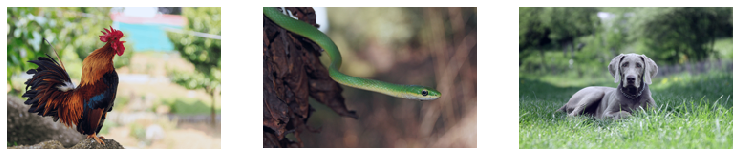

In [12]:
plt.figure(figsize=(13, 3))

for idx, (img, processed_img, class_id, filename) in enumerate(image_generator()):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(make_image(processed_img.detach().numpy().squeeze()))
    plt.axis('off')

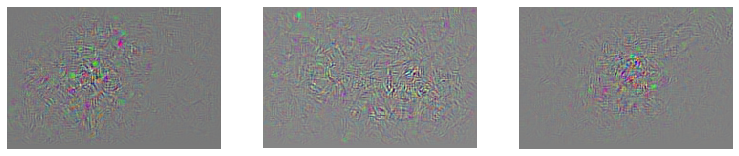

In [13]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Vanilla'][idx])
    plt.axis('off')

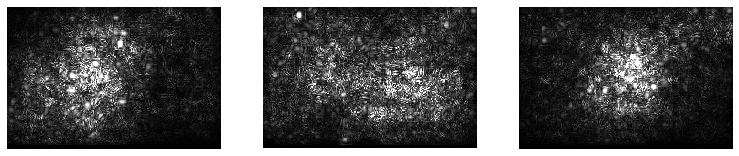

In [14]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Vanilla_grayscale'][idx])
    plt.axis('off')

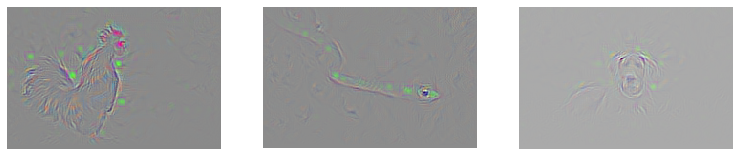

In [15]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Guided'][idx])
    plt.axis('off')

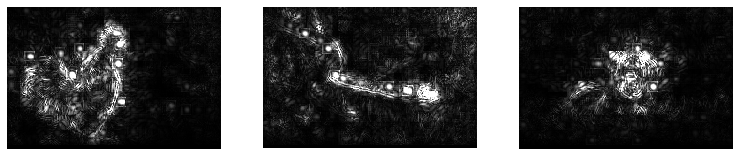

In [16]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Guided_grayscale'][idx])
    plt.axis('off')

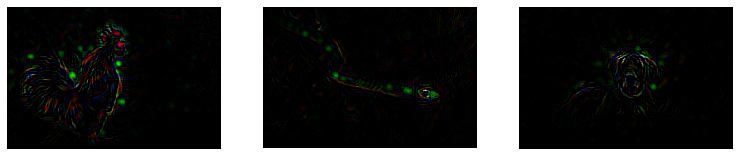

In [17]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Guided_pos_saliency'][idx])
    plt.axis('off')

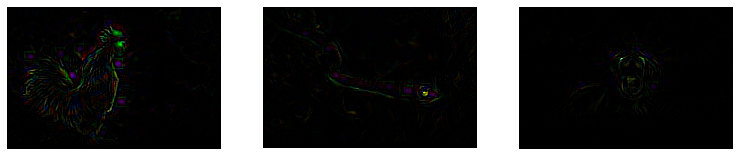

In [18]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Guided_neg_saliency'][idx])
    plt.axis('off')

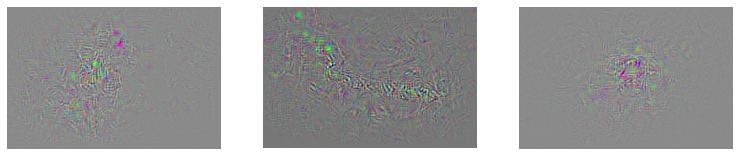

In [19]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Integrated'][idx])
    plt.axis('off')

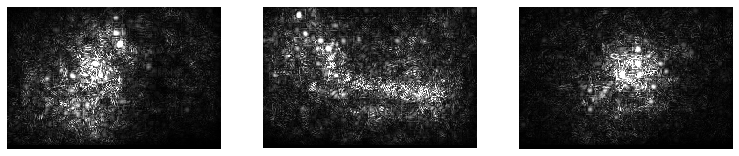

In [20]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['Integrated_grayscale'][idx])
    plt.axis('off')

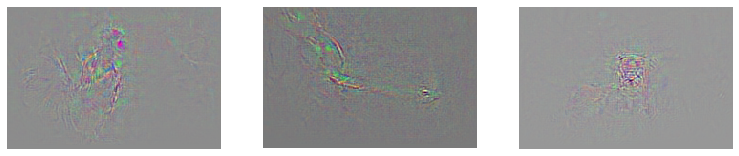

In [21]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['SmoothVanila'][idx])
    plt.axis('off')

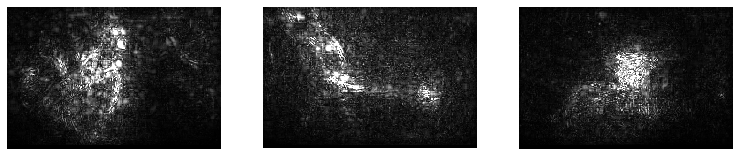

In [22]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['SmoothVanila_grayscale'][idx])
    plt.axis('off')

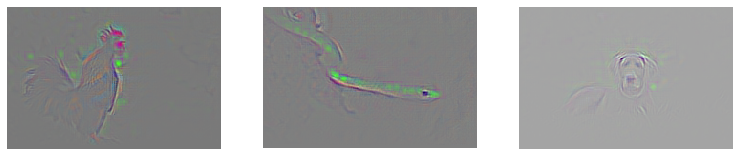

In [23]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['SmoothGuided'][idx])
    plt.axis('off')

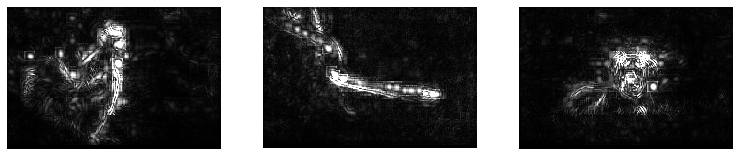

In [24]:
plt.figure(figsize=(13, 3))

for idx in range(3):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(results['SmoothGuided_grayscale'][idx])
    plt.axis('off')

Ссылки:
* [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)
* [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)
* [Not Just A Black Box:
Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1605.01713)
* [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)
* [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
* [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/abs/1312.6034)
* [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825)